<ipython-input-4-46e136b33231>:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sentiment'].fillna(0, inplace=True)



Model Performance Metrics:
Mean Squared Error (MSE): 4548077.14
Root Mean Squared Error (RMSE): 2132.62
Mean Absolute Error (MAE): 1061.41
R-squared (R²): 0.9833

Predicted vs Actual Prices:
            Actual Price  Predicted Price
Date                                     
2022-12-09  17091.144531     17714.912871
2018-02-02  11512.599609     10730.859277
2021-11-25  50429.859375     50020.897579
2017-06-21   2667.760010      3458.303486
2022-12-13  18869.587891     20435.941367
2017-01-05   1042.900024      1043.775883
2021-03-30  53555.109375     51733.994414
2023-01-22  24436.353516     25053.486973
2017-05-01   2286.409912      2093.272174
2018-09-05   6622.479980      7859.672456
2023-07-11  29429.591797     28191.071035
2017-07-30   4579.020020      4370.939629
2021-03-15  63109.695313     58419.175352
2017-05-11   2947.709961      2758.219631
2022-01-26  39214.218750     35331.469395
2018-10-07   6461.009766      5857.691514
2017-10-10   7143.580078      5228.324863
2015-05-08

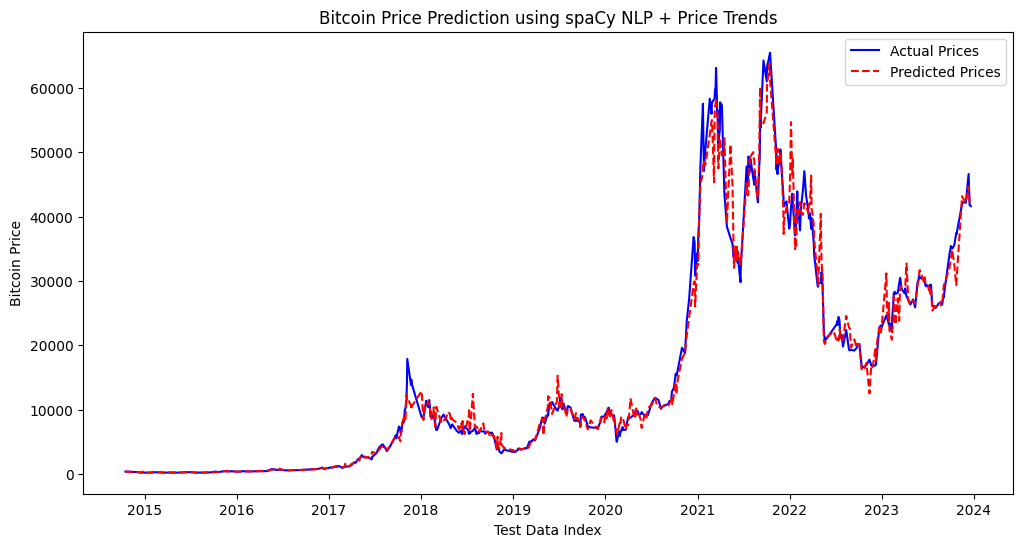

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # 📌 Seaborn for better visualization
import requests
import spacy  # 📌 Added spaCy for NLP processing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# 📌 Load Bitcoin dataset
df = pd.read_csv('/content/BTC-USD (2014-2024).csv')

# Convert 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# 📌 Function to fetch Bitcoin news
def fetch_bitcoin_news():
    api_key = "e29b9d11722d495da883a2bb04e320b6"  # Replace with your actual API key
    url = f"https://newsapi.org/v2/everything?q=bitcoin&language=en&apiKey={api_key}"
    response = requests.get(url).json()

    headlines = []
    dates = []

    if "articles" in response:
        for article in response['articles']:
            headlines.append(article['title'])
            dates.append(article['publishedAt'][:10])  # Extract YYYY-MM-DD

    return pd.DataFrame({'Date': dates, 'Headline': headlines})

# Fetch news headlines
news_df = fetch_bitcoin_news()
news_df['Date'] = pd.to_datetime(news_df['Date'])

# 📌 Perform NLP Processing using spaCy
def analyze_sentiment(text):
    doc = nlp(text)  # Process text with spaCy
    sentiment_score = sum(token.sentiment for token in doc) / len(doc) if len(doc) > 0 else 0
    return sentiment_score

news_df['Sentiment'] = news_df['Headline'].apply(analyze_sentiment)

# Aggregate sentiment scores per day
daily_sentiment = news_df.groupby('Date')['Sentiment'].mean()

# Merge sentiment scores with Bitcoin dataset
df = df.join(daily_sentiment, how='left')

# Fill missing sentiment values with 0 (neutral)
df['Sentiment'].fillna(0, inplace=True)

# 📌 Add More Features
df['MA_7'] = df['Close'].rolling(window=7).mean()  # 7-day moving average
df['MA_30'] = df['Close'].rolling(window=30).mean()  # 30-day moving average
df['Volatility_7'] = df['Close'].rolling(window=7).std()
df['Price_Change'] = df['Close'].diff()
df['Close_Lag_1'] = df['Close'].shift(1)

# 📌 Define Target (Close Price in the Future)
predictionDays = 30
df['Prediction'] = df['Close'].shift(-predictionDays)

# Drop NaN values
df.dropna(inplace=True)

# 📌 Select Features
X = df[['Close', 'MA_7', 'MA_30', 'Volatility_7', 'Price_Change', 'Close_Lag_1', 'Sentiment']]
y = df['Prediction']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a **Random Forest Model** for better predictions
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Convert predictions and actual values into a DataFrame
predictions_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': rf_predictions})
predictions_df.index = y_test.index  # Align index with actual data

# 📌 Calculate Model Accuracy Metrics
mse = metrics.mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, rf_predictions)
r2 = metrics.r2_score(y_test, rf_predictions)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.4f}")

# 📌 Display Predicted vs Actual Prices
print("\nPredicted vs Actual Prices:")
print(predictions_df.head(20))  # Show the first 20 predictions

# 📌 Improved Visualization using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=predictions_df, x=predictions_df.index, y="Actual Price", label="Actual Prices", color='blue')
sns.lineplot(data=predictions_df, x=predictions_df.index, y="Predicted Price", label="Predicted Prices", color='red', linestyle='dashed')
plt.title("Bitcoin Price Prediction using spaCy NLP + Price Trends")
plt.xlabel("Test Data Index")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()
